***Participantes (RM - NOME):***<br>
Vitor Luiz Carvalhal - 337129<br>
Ricardo Fabbro Antonelli - 339505<br>
Bartira Lira Lafiandre - 340177<br>
Tiago Batista Pessoa - 339575<br>

In [217]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import missingno as msno
import seaborn as sbs
import sklearn.metrics as sm
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import joblib
import plotly.io as pio
pio.renderers.default = "vscode"
from pandas import read_csv
from sklearn.ensemble import RandomForestRegressor as rfr
from sklearn.linear_model import LinearRegression as lr
from sklearn import metrics as me
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
#necessita do pydot pip install pydot
from keras.utils.vis_utils import plot_model

### **Preparação**

In [218]:
#recupera os dados da planilha origem
filename= "./data/solicitacoescredito.csv"
file= pd.read_csv(filename,sep=",",decimal='.', engine='python')
file = file.reindex(sorted(file.columns), axis=1)
#file.drop(file.columns[0],inplace=True,axis=1)
#file.drop(["cluster"],inplace=True,axis=1)
file.head()

,anoFundacao,ativoCirculante,capitalSocial,cnpjSemTraco,custos,dashboardCorrelacao,dataAprovadoEmComite,dataAprovadoNivelAnalista,definicaoRisco,diferencaPercentualRisco,...,primeiraCompra,razaoSocial,restricoes,scorePontualidade,status,titulosEmAberto,totalAtivo,totalPatrimonioLiquido,valorAprovado,valorSolicitado
0,2003.0,NaN,90000.0,KEBE17609492220843,0.0,0.000000,NaN,2020-02-03T20:57:33,De 11 a 30 % - Baixo,0.716981,...,2015-12-10T00:00:00,James Richardson-Patel,False,1.0,AprovadoAnalista,0.00,NaN,NaN,50000.0,50000.0
1,NaN,NaN,NaN,JRBK88908250677300,NaN,0.000000,NaN,NaN,De 0 a 10 % - Muito Baixo,1.000000,...,2019-06-12T17:28:31,Dr. Geoffrey Walsh,NaN,0.0,DocumentacaoReprovada,0.00,NaN,NaN,NaN,10000.0
2,2014.0,NaN,20000.0,GCVQ28531614261293,0.0,0.000000,NaN,2020-02-04T16:40:49,De 11 a 30 % - Baixo,0.716981,...,2019-11-27T00:00:00,Joanna Hudson,False,1.0,AprovadoAnalista,0.00,NaN,NaN,20000.0,20000.0
3,2013.0,NaN,30000.0,KJND32266018316396,0.0,0.485811,NaN,2020-02-04T16:37:52,De 51 a 80 % - Alto,0.396226,...,2017-02-13T17:20:27,Gordon Jones-Hopkins,False,0.0,AprovadoAnalista,0.00,NaN,NaN,15000.0,25000.0
4,2002.0,14758917.0,75000.0,CGQN15826802440348,40680051.0,0.000000,NaN,2020-02-04T15:06:28,De 11 a 30 % - Baixo,0.830189,...,2010-07-13T00:00:00,Nigel Lee,False,1.0,AprovadoAnalista,1486.95,25793410.0,14544378.0,50000.0,50000.0


AxesSubplot(0.125,0.3515;0.775x0.5285) 



Text(0.5, 1.0, 'Correlation matrix')

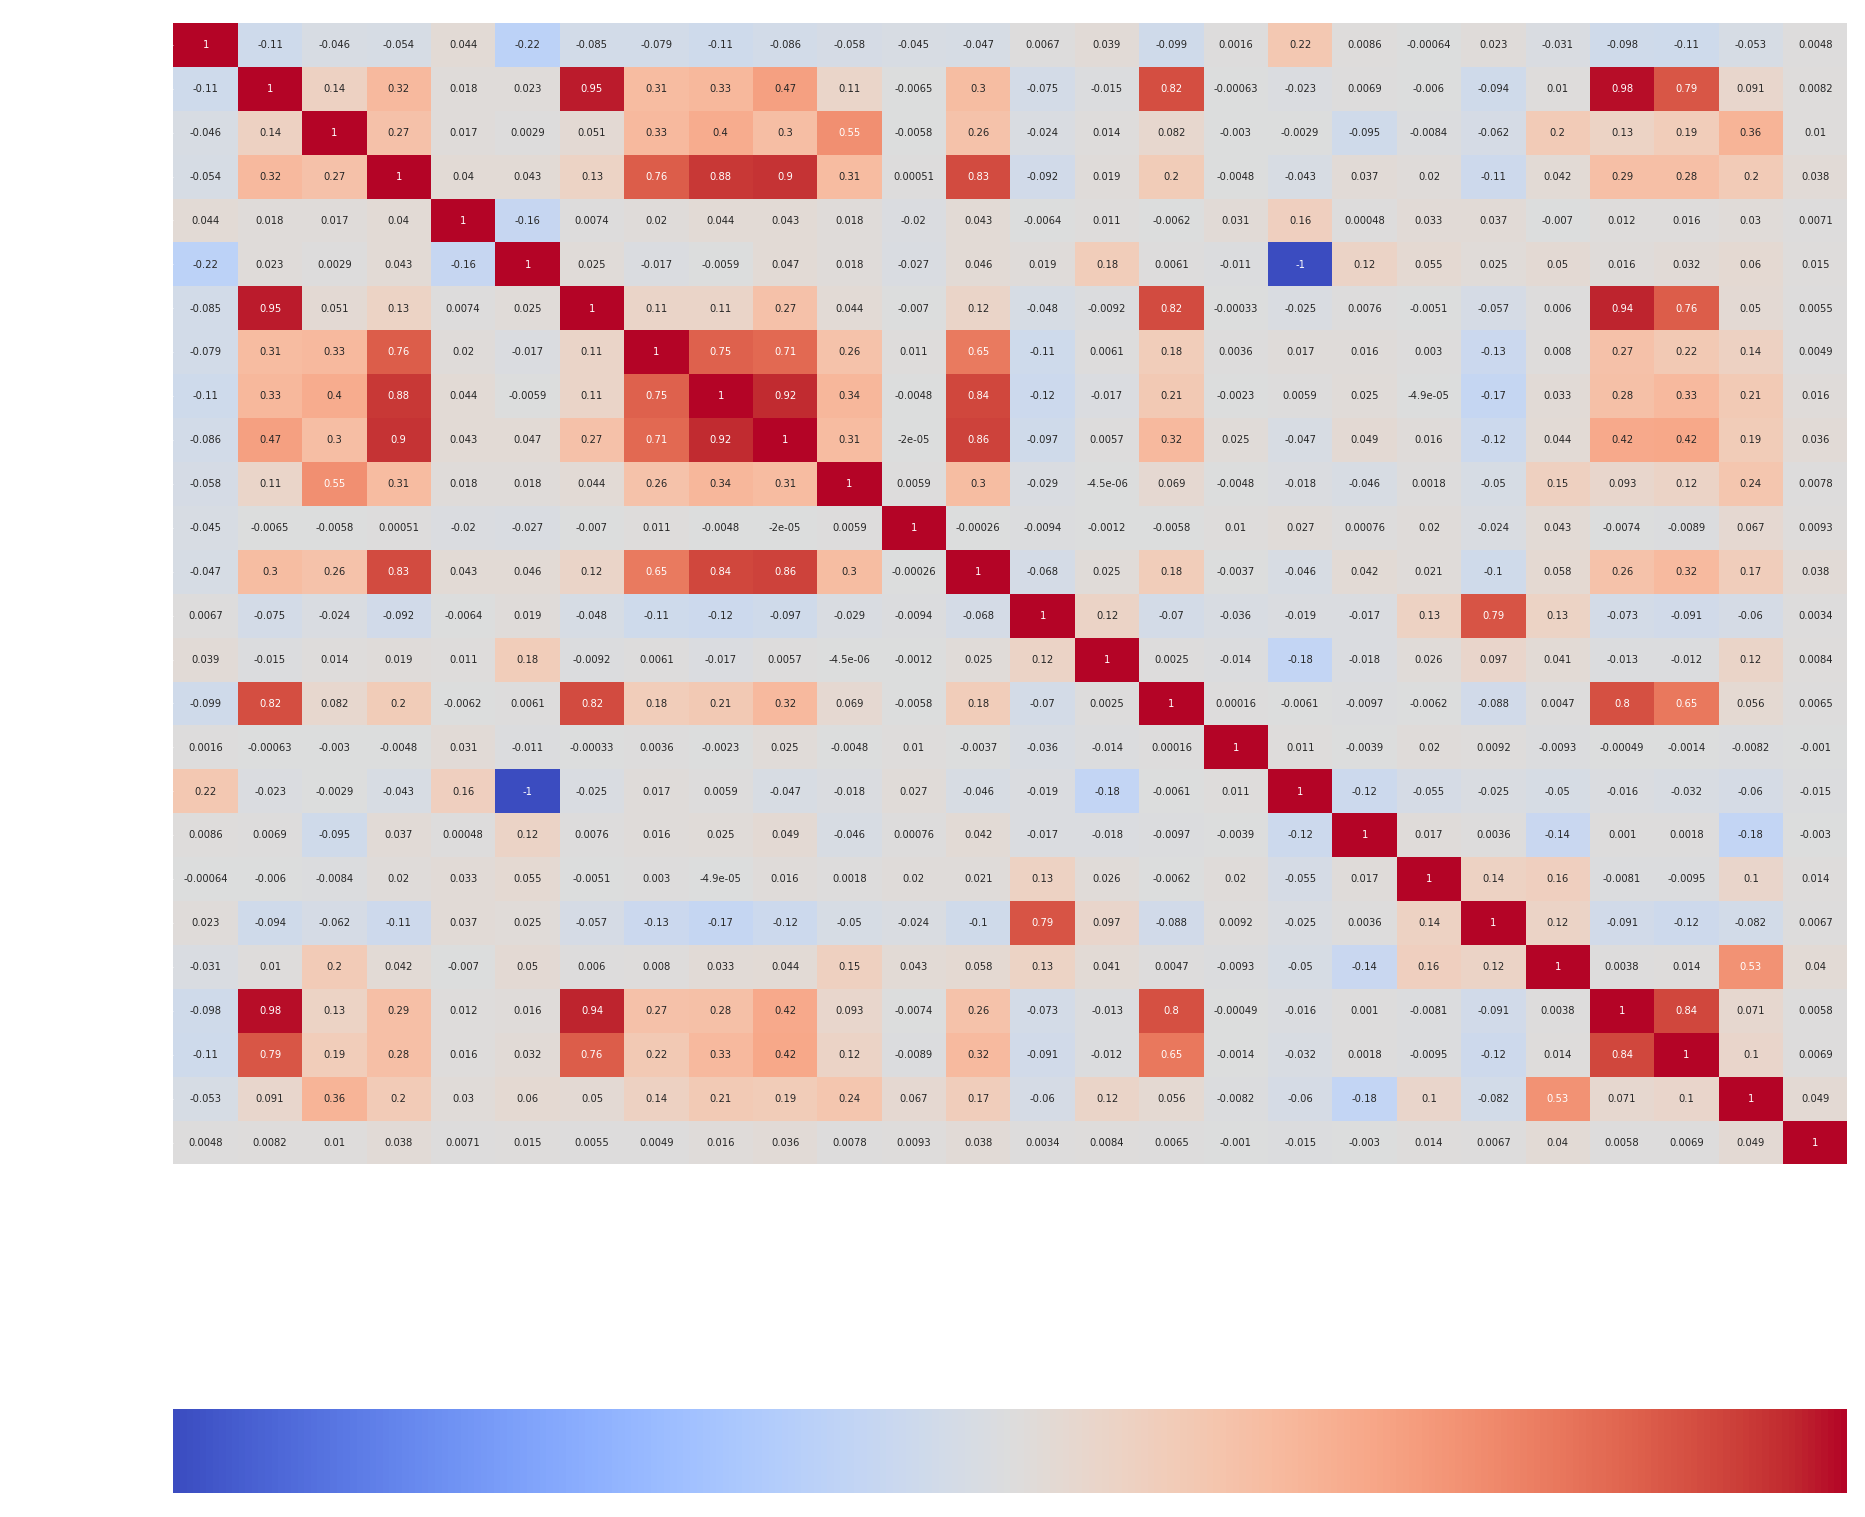

In [196]:
#Vendo as correlações existentes
plt.figure(figsize=(30,30)) 
print(sbs.heatmap(file.corr(), annot=True, cmap="coolwarm",cbar_kws= {'orientation': 'horizontal'}),"\n")
plt.title('Correlation matrix')

In [219]:
#remove correlações acima de 90% e dropa algumas colunas
correlated_features = set()
correlation_matrix = file.corr()
for i in range(len(correlation_matrix .columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

file.drop(labels=correlated_features, axis=1, inplace=True)

file.drop(["numero_solicitacao",
         "cnpjSemTraco",
         "nomeFantasia",
         "razaoSocial",
         "primeiraCompra",
         "dataAprovadoEmComite",
         "periodoBalanco",
         "intervaloFundacao",
         "dataAprovadoNivelAnalista",
         "periodoDemonstrativoEmMeses",
         "anoFundacao"], axis=1, inplace=True)


file["definicaoRisco"]= np.where(file["definicaoRisco"]=="De 0 a 10 % - Muito Baixo",1,file["definicaoRisco"])
file["definicaoRisco"]= np.where(file["definicaoRisco"]=="De 11 a 30 % - Baixo",2,file["definicaoRisco"])
file["definicaoRisco"]= np.where(file["definicaoRisco"]=="De 31 a 50 % - Médio",3,file["definicaoRisco"])
file["definicaoRisco"]= np.where(file["definicaoRisco"]=="De 51 a 80 % - Alto",4,file["definicaoRisco"])
file["definicaoRisco"]=np.int64(file["definicaoRisco"])

file.drop(["status","diferencaPercentualRisco"],axis='columns',inplace=True)

In [220]:
#Separa apenas os registros que possuam valor para a coluna da nossa variavel target e depois dropa as linhas com na
file=file[file["valorAprovado"].notna()]
file=file.drop_duplicates()
file=file.dropna()

<AxesSubplot:>

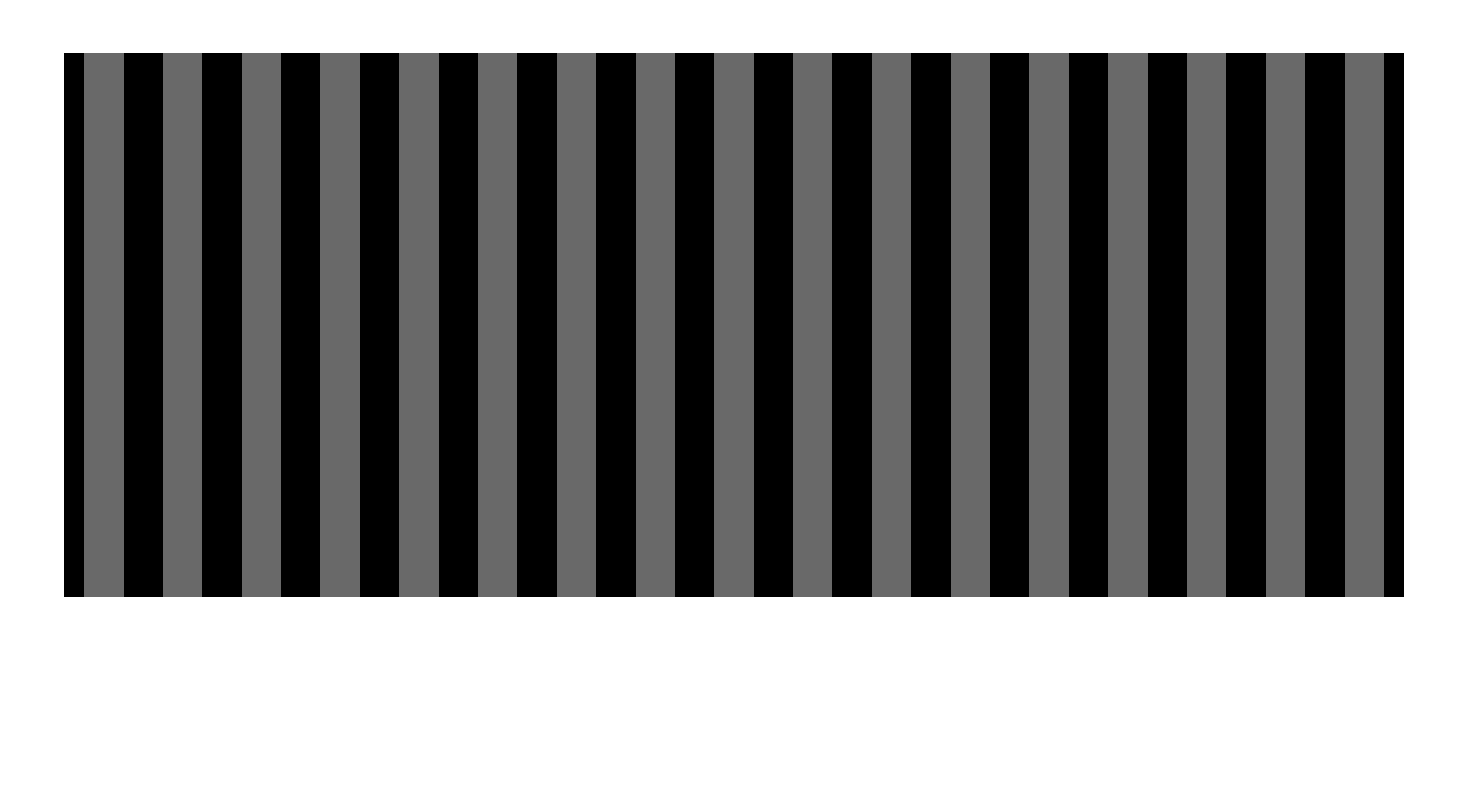

In [202]:
#visão do resultado final
%matplotlib inline
msno.bar(file)

In [203]:
print(round(file.corr(method='pearson')["valorAprovado"]*100,2).sort_values(ascending=False),'\n')

valorAprovado                  100.00
titulosEmAberto                 69.45
custos                          29.03
endividamento                   20.53
prazoMedioRecebimentoVendas     18.07
limiteEmpresaAnaliseCredito     16.45
maiorAtraso                      9.13
capitalSocial                    5.97
ativoCirculante                  5.53
scorePontualidade                4.45
valorSolicitado                  4.12
margemBrutaAcumulada             0.14
dashboardCorrelacao             -1.24
definicaoRisco                  -8.63
percentualProtestos               NaN
Name: valorAprovado, dtype: float64 



In [204]:
file.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3502 entries, 4 to 8961
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ativoCirculante              3502 non-null   float64
 1   capitalSocial                3502 non-null   float64
 2   custos                       3502 non-null   float64
 3   dashboardCorrelacao          3502 non-null   float64
 4   definicaoRisco               3502 non-null   int64  
 5   empresa_MeEppMei             3502 non-null   object 
 6   endividamento                3502 non-null   float64
 7   limiteEmpresaAnaliseCredito  3502 non-null   float64
 8   maiorAtraso                  3502 non-null   int64  
 9   margemBrutaAcumulada         3502 non-null   float64
 10  percentualProtestos          3502 non-null   float64
 11  prazoMedioRecebimentoVendas  3502 non-null   int64  
 12  restricoes                   3502 non-null   object 
 13  scorePontualidade 

### **Modelo para Pequena Empresa**<br>
*Abordagem por RandonForestRegression*

In [205]:
pequena_empresa = file[file["empresa_MeEppMei"]==1]
pequena_empresa.shape

(1226, 17)

In [206]:
targetcol = 'valorAprovado'
y_0 = pequena_empresa[targetcol]
x_0 = pequena_empresa.iloc[:, pequena_empresa.columns != 'valorAprovado']

#X_norm = StandardScaler().fit_transform(x)

#clf = rfr()
#clf.fit(X=X_norm, y=y)
#clf.all_coln = all_coln

In [207]:
from sklearn.model_selection import train_test_split

X_0_train, X_0_test, y_0_train, y_0_test = train_test_split(x_0, y_0, test_size = 0.25, random_state = 0)

> Fazendo RandonForestRegression

In [208]:
clf = rfr(n_estimators = 50, random_state = 0)
clf.fit(X_0_train, y_0_train)

clf_acuracia = clf.score(X=x_0, y=y_0)
print("Acuracia (r²): [{0}]".format(clf_acuracia))

Acuracia (r²): [0.9711640463375522]


In [209]:
y_pred = clf.predict(X_0_test)

print('Mean Absolute Error(MAE):', me.mean_absolute_error(y_0_test, y_pred))  
print('Mean Squared Error(MSE):', me.mean_squared_error(y_0_test, y_pred))  
print('Root Mean Squared Error(RMSE):', np.sqrt(me.mean_squared_error(y_0_test, y_pred)))

Mean Absolute Error(MAE): 22826.54790341761
Mean Squared Error(MSE): 1991476195.813999
Root Mean Squared Error(RMSE): 44625.95876632791


In [210]:
#optamos por seguir com o RandonForestRegression pois teve a melhor acuracia depois de testar regressao linear simples e MLP.

model_name = "indicacao_valor_maximo_peq.pkl"
filename = "./modelo/" + model_name
joblib.dump(value=clf, filename=filename)

['./modelo/indicacao_valor_maximo_peq.pkl']

### **Modelo para Grande Empresa**<br>
*Abordagem por RandonForestRegression*

In [221]:
grande_empresa = file[file["empresa_MeEppMei"]==0]
grande_empresa.shape

(2276, 17)

In [222]:
targetcol = 'valorAprovado'
y_1 = grande_empresa[targetcol]
x_1 = grande_empresa.iloc[:, grande_empresa.columns != 'valorAprovado']

In [223]:
from sklearn.model_selection import train_test_split

X_1_train, X_1_test, y_1_train, y_1_test = train_test_split(x_1, y_1, test_size = 0.25, random_state = 0)

In [224]:
clf_g = rfr(n_estimators = 50, random_state = 0)
clf_g.fit(X_1_train, y_1_train)

clf_g_acuracia = clf_g.score(X=x_1, y=y_1)
print("Acuracia (r²): [{0}]".format(clf_g_acuracia))

Acuracia (r²): [0.9650315522485833]


In [225]:
y_pred_g = clf_g.predict(X_1_test)

print('Mean Absolute Error(MAE):', me.mean_absolute_error(y_1_test, y_pred_g))  
print('Mean Squared Error(MSE):', me.mean_squared_error(y_1_test, y_pred_g))  
print('Root Mean Squared Error(RMSE):', np.sqrt(me.mean_squared_error(y_1_test, y_pred_g)))

Mean Absolute Error(MAE): 47452.098132061255
Mean Squared Error(MSE): 24280926129.479458
Root Mean Squared Error(RMSE): 155823.3812028203


In [226]:
#optamos por seguir com o RandonForestRegression pois teve a melhor acuracia depois de testar regressao linear simples e MLP.

model_name = "indicacao_valor_maximo_gra.pkl"
filename = "./modelo/" + model_name
joblib.dump(value=clf_g, filename=filename)

['./modelo/indicacao_valor_maximo_gra.pkl']

> Fazendo linearRegression

In [180]:
lrl = lr()
lrl.fit(X_1_train, y_1_train)

lrl_acuracia = lrl.score(X=x_1, y=y_1)
print("Acuracia (r²): [{0}]".format(lrl_acuracia))

Acuracia (r²): [0.5436034485237001]


In [181]:
y_pred_linear = lrl.predict(X_1_test)

print('Mean Absolute Error(MAE):', me.mean_absolute_error(y_1_test, y_pred_linear))  
print('Mean Squared Error(MSE):', me.mean_squared_error(y_1_test, y_pred_linear))  
print('Root Mean Squared Error(RMSE):', np.sqrt(me.mean_squared_error(y_1_test, y_pred_linear)))

Mean Absolute Error(MAE): 182742.65871801082
Mean Squared Error(MSE): 115556133628.04666
Root Mean Squared Error(RMSE): 339935.4845085265


> usando MLP

In [182]:
seed = 7
test_size = 0.30

scalar = MinMaxScaler()
X = scalar.fit_transform(x_1)

X_1_train, X_1_test, y_1_train, y_1_test = train_test_split(X, y_1, test_size=test_size, random_state=seed)

In [183]:
qtd_features = len(X[0,:])
qtd_amostras = len(X[:,0])

model = Sequential()
model.add(Dense(12, input_dim=qtd_features, activation='relu'))
model.add(Dense(12, activation='relu'))
#Adiciona uma camada de saída sem função de ativação fazendo a apenas a multiplicação das caracteristicas x pesos
model.add(Dense(1))

model.compile(loss='mse',optimizer='adam', metrics=['mae', 'mse'])

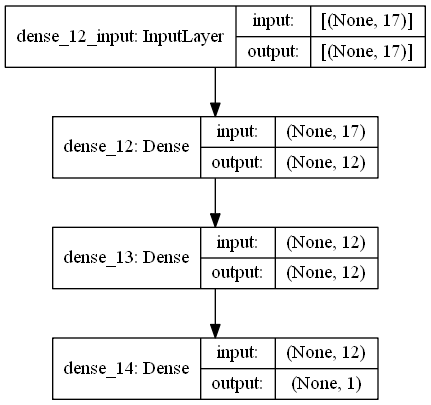

In [184]:
plot_model(model, to_file='mlp-seq.png', show_shapes=True, show_layer_names=True)


In [186]:
model.fit(X_1_train, y_1_train, epochs=300, batch_size=4)

Epoch 1/300
403/403 [==============================] - 1s 727us/step - loss: 313364971520.0000 - mae: 273316.7188 - mse: 313364971520.0000
Epoch 2/300
403/403 [==============================] - 0s 647us/step - loss: 313317064704.0000 - mae: 273229.9688 - mse: 313317064704.0000
Epoch 3/300
403/403 [==============================] - 0s 755us/step - loss: 313137463296.0000 - mae: 272912.1250 - mse: 313137463296.0000
Epoch 4/300
403/403 [==============================] - 0s 652us/step - loss: 312733499392.0000 - mae: 272237.5000 - mse: 312733499392.0000
Epoch 5/300
403/403 [==============================] - 0s 770us/step - loss: 312059559936.0000 - mae: 271037.7500 - mse: 312059559936.0000
Epoch 6/300
403/403 [==============================] - 0s 849us/step - loss: 311125213184.0000 - mae: 269371.5000 - mse: 311125213184.0000
Epoch 7/300
403/403 [==============================] - 0s 891us/step - loss: 309846802432.0000 - mae: 267211.9375 - mse: 309846802432.0000
Epoch 8/300
403/403 [======

In [187]:
y_pred_MLP = model.predict(X_1_test)

In [188]:
print('Mean Absolute Error(MAE):', me.mean_absolute_error(y_1_test, y_pred_MLP))  
print('Mean Squared Error(MSE):', me.mean_squared_error(y_1_test, y_pred_MLP))  
print('Root Mean Squared Error(RMSE):', np.sqrt(me.mean_squared_error(y_1_test, y_pred_MLP)))

Mean Absolute Error(MAE): 239055.12807525325
Mean Squared Error(MSE): 139177972997.1083
Root Mean Squared Error(RMSE): 373065.6416732963


In [122]:
#optamos por seguir com o RandonForestRegression pois teve a melhor acuracia

model_name = "indicacao_valor_maximo.pkl"
filename = "./modelo/" + model_name
joblib.dump(value=clf, filename=filename)

['./modelo/indicacao_valor_maximo.pkl']